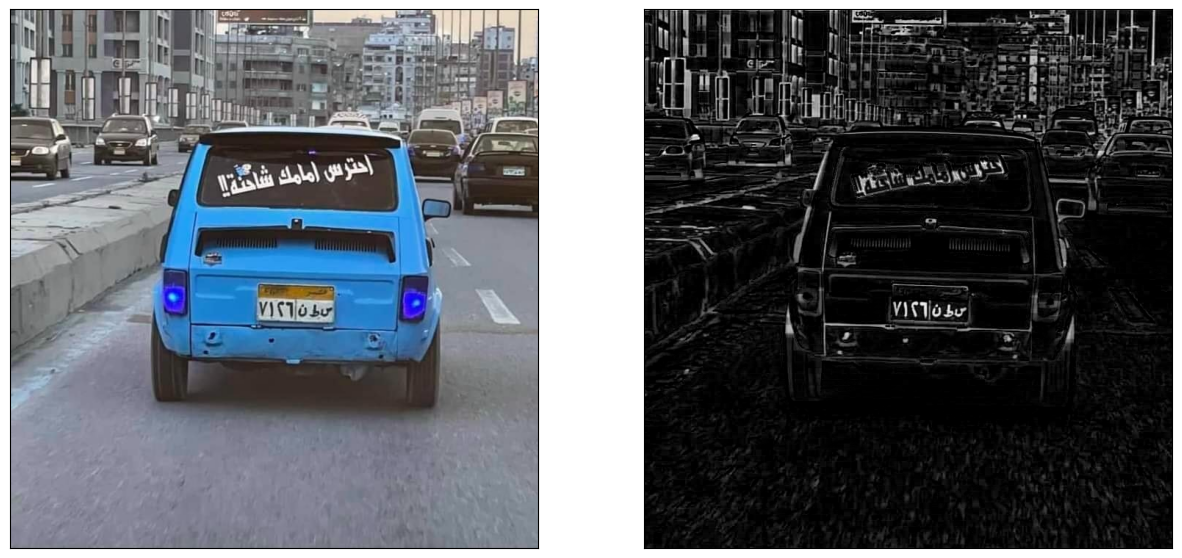

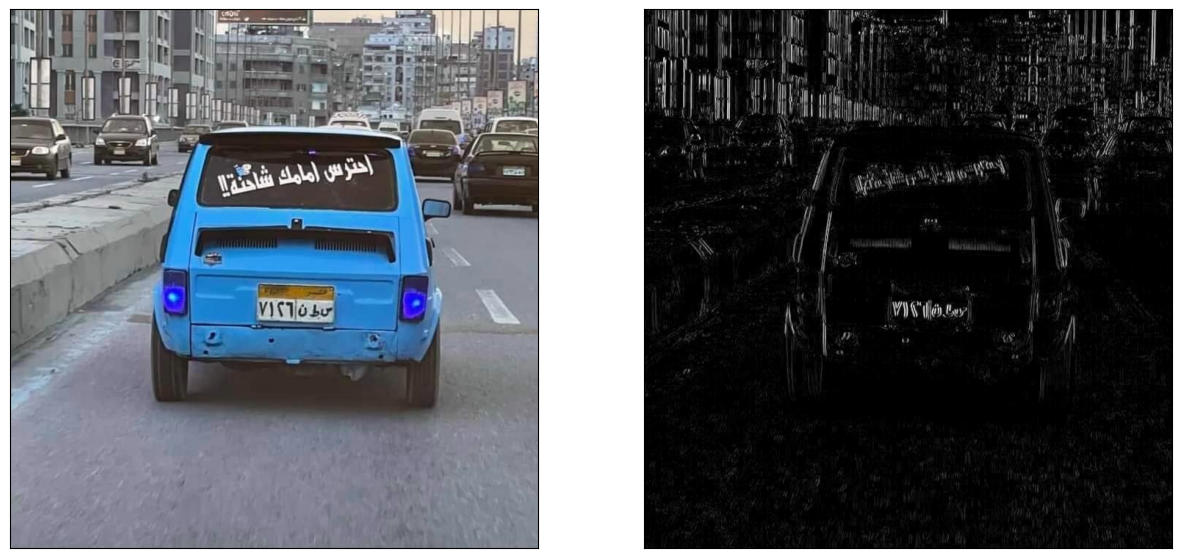

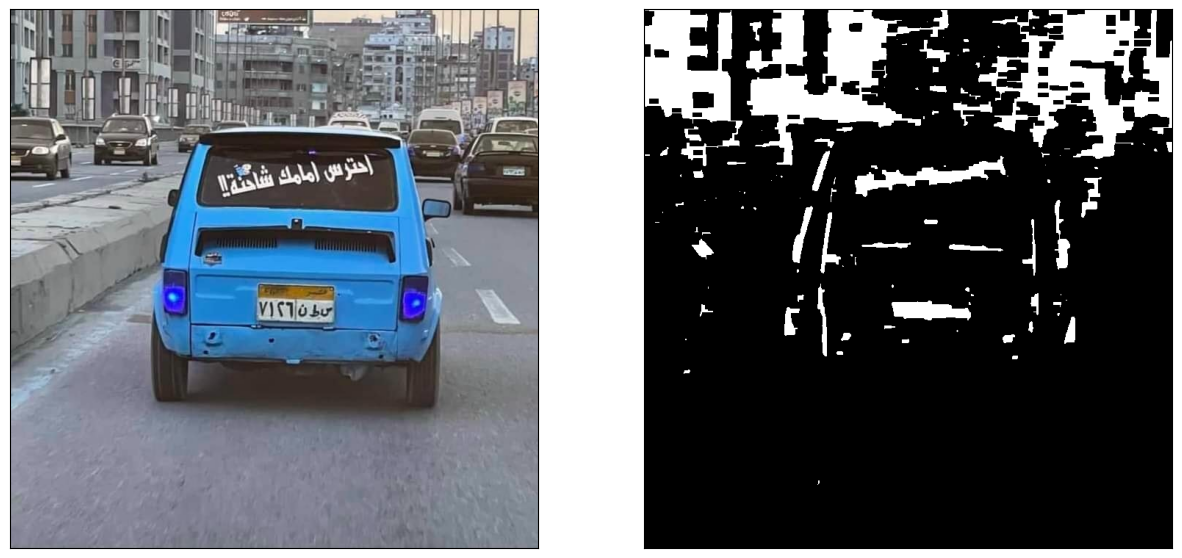

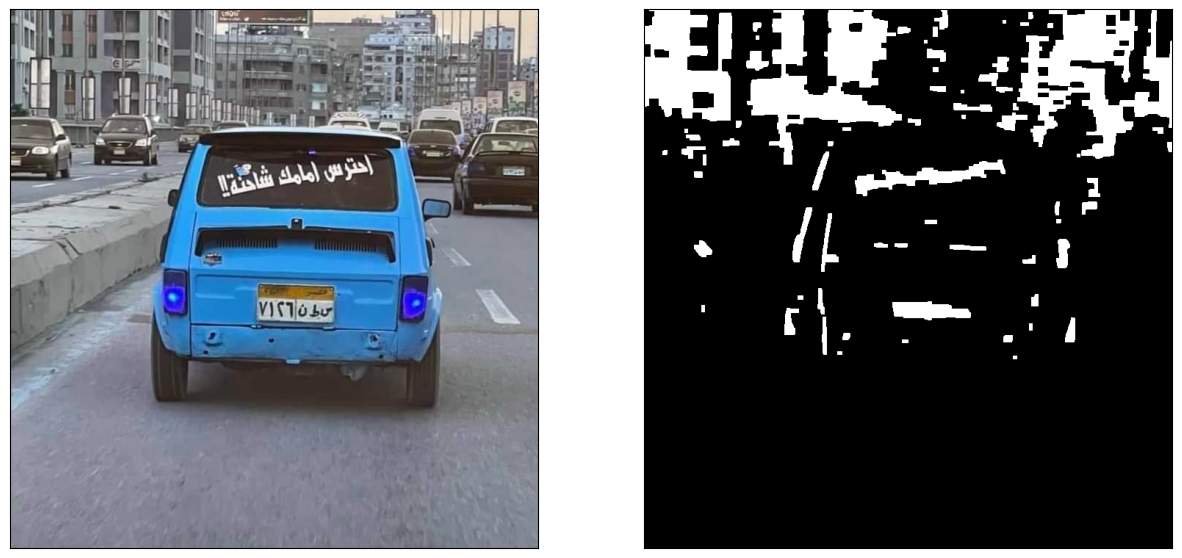

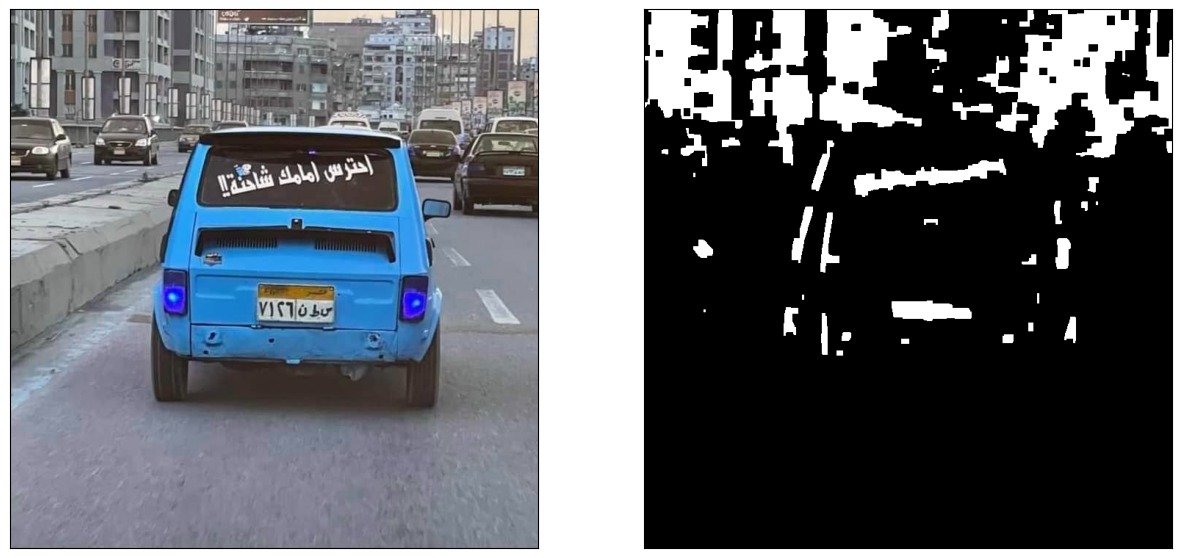

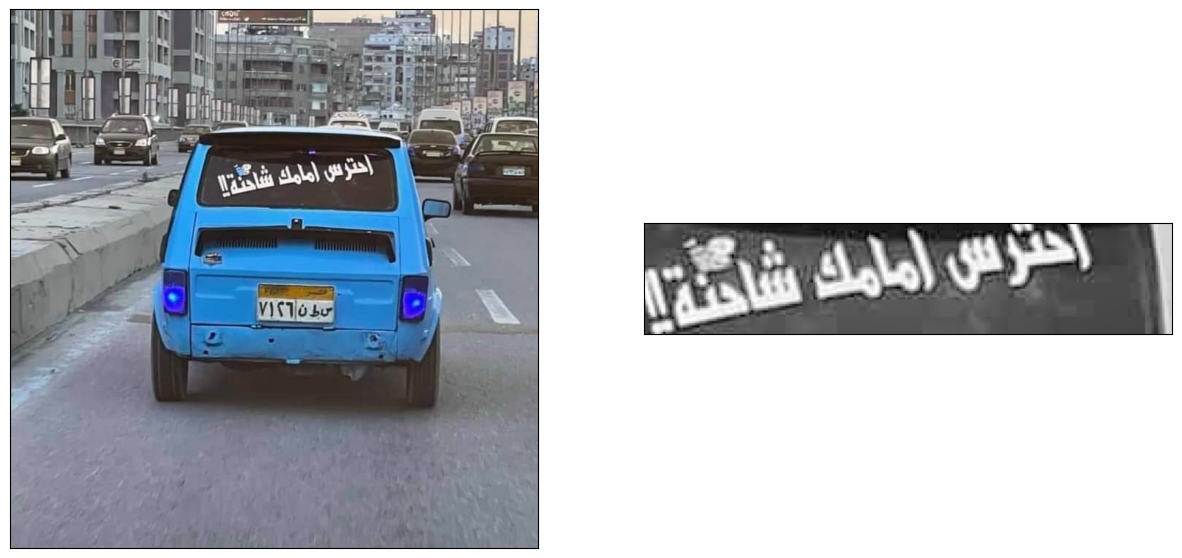

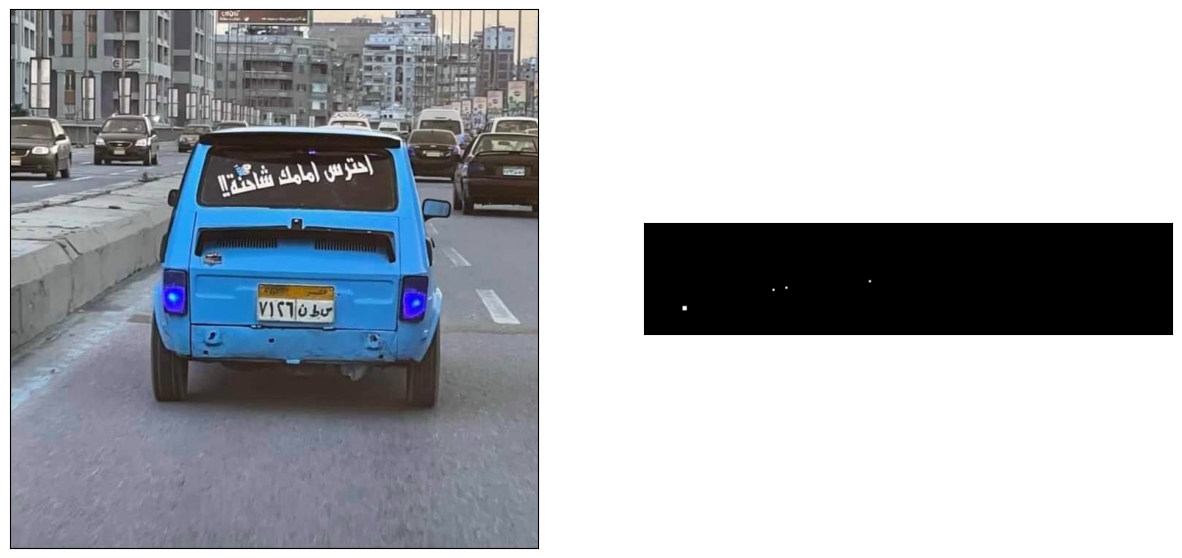

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
from skimage.segmentation import clear_border
import easyocr

minAR = 2
maxAR = 4


def plot_images(img1, img2, title1="", title2=""):
    fig = plt.figure(figsize=[15, 15])
    ax1 = fig.add_subplot(121)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)

    ax2 = fig.add_subplot(122)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)


image = cv2.imread("../../data/Vehicles/0001.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
gray = clahe.apply(gray)

squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]


rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 6))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")
plot_images(image, blackhat)
plot_images(image, gradX)


gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plot_images(image, thresh)


thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

plot_images(image, thresh)

thresh = cv2.bitwise_and(thresh, thresh, mask=light)
thresh = cv2.dilate(thresh, None, iterations=5)
thresh = cv2.erode(thresh, None, iterations=4)

plot_images(image, thresh)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

lpCnt = None
roi = None

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if minAR <= ar < maxAR:
        lpCnt = c
        licensePlate = gray[y : y + h, x : x + w + 40]
        roi = cv2.threshold(
            licensePlate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
        )[1]
        break


plot_images(image, licensePlate)
roi = clear_border(roi)
plot_images(image, roi)


# def convert(bx, by, bw, bh, w, h):
#     xmx = (2 * w * bx + w * bw) / 2
#     xmn = 2 * w * bx - xmx
#     ymx = (2 * h * by + h * bh) / 2
#     ymn = 2 * h * by - ymx
#     return xmn, xmx, ymn, ymx


# def benchmark(image, roi: np.ndarray, labelBoundingBox: str):
#     easyocr_reader = easyocr.Reader(["ar"])
#     results = easyocr_reader.readtext(roi)

#     # Cut out label bounding box
#     h = image.shape[0]
#     w = image.shape[1]
#     # Convert string to float
#     labelBoundingBox = [float(i) for i in labelBoundingBox]

#     xmn, xmx, ymn, ymx = convert(*labelBoundingBox[1:], w, h)

#     def rint(x):
#         return int(round(x))

#     labelArea = image[rint(ymn) : rint(ymx), rint(xmn) : rint(xmx)]

#     plot_images(image, labelArea, "image", "label")
#     results_label = easyocr_reader.readtext(labelArea)
#     print("Results: ", results)
#     print("Results Label: ", results_label)
#     return results[0][1] == results_label[0][1]


# label = label = open("../../data/Vehicles Labeling/0001.txt")
# label = label.read()
# print(benchmark(gray, roi, label.split(" ")))